<a href="https://colab.research.google.com/github/Rojan116/Track/blob/master/Behavioral_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Rojan116/Track

fatal: destination path 'Track' already exists and is not an empty directory.


In [2]:
!ls Track

Behavioral_cloning.ipynb  driving_log.csv  IMG


In [3]:
!pip install imgaug

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Dense, Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import random
import ntpath
import os

Using TensorFlow backend.


In [5]:
datadir = 'Track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth',-1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/home/rojan/Desktop/Data/IMG/center_2019_04_19_19_12_23_291.jpg,/home/rojan/Desktop/Data/IMG/left_2019_04_19_19_12_23_291.jpg,/home/rojan/Desktop/Data/IMG/right_2019_04_19_19_12_23_291.jpg,0.0,0.0,0.0,0.000078
1,/home/rojan/Desktop/Data/IMG/center_2019_04_19_19_12_23_384.jpg,/home/rojan/Desktop/Data/IMG/left_2019_04_19_19_12_23_384.jpg,/home/rojan/Desktop/Data/IMG/right_2019_04_19_19_12_23_384.jpg,0.0,0.0,0.0,0.000078
2,/home/rojan/Desktop/Data/IMG/center_2019_04_19_19_12_23_485.jpg,/home/rojan/Desktop/Data/IMG/left_2019_04_19_19_12_23_485.jpg,/home/rojan/Desktop/Data/IMG/right_2019_04_19_19_12_23_485.jpg,0.0,0.0,0.0,0.000081
3,/home/rojan/Desktop/Data/IMG/center_2019_04_19_19_12_23_589.jpg,/home/rojan/Desktop/Data/IMG/left_2019_04_19_19_12_23_589.jpg,/home/rojan/Desktop/Data/IMG/right_2019_04_19_19_12_23_589.jpg,0.0,0.0,0.0,0.000078
4,/home/rojan/Desktop/Data/IMG/center_2019_04_19_19_12_23_696.jpg,/home/rojan/Desktop/Data/IMG/left_2019_04_19_19_12_23_696.jpg,/home/rojan/Desktop/Data/IMG/right_2019_04_19_19_12_23_696.jpg,0.0,0.0,0.0,0.000079


In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_04_19_19_12_23_291.jpg,left_2019_04_19_19_12_23_291.jpg,right_2019_04_19_19_12_23_291.jpg,0.0,0.0,0.0,0.000078
1,center_2019_04_19_19_12_23_384.jpg,left_2019_04_19_19_12_23_384.jpg,right_2019_04_19_19_12_23_384.jpg,0.0,0.0,0.0,0.000078
2,center_2019_04_19_19_12_23_485.jpg,left_2019_04_19_19_12_23_485.jpg,right_2019_04_19_19_12_23_485.jpg,0.0,0.0,0.0,0.000081
3,center_2019_04_19_19_12_23_589.jpg,left_2019_04_19_19_12_23_589.jpg,right_2019_04_19_19_12_23_589.jpg,0.0,0.0,0.0,0.000078
4,center_2019_04_19_19_12_23_696.jpg,left_2019_04_19_19_12_23_696.jpg,right_2019_04_19_19_12_23_696.jpg,0.0,0.0,0.0,0.000079


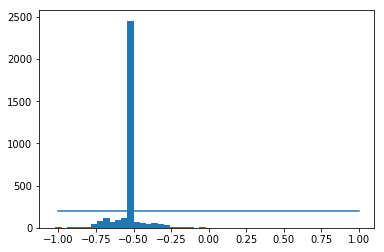

In [7]:
num_bins  = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'],num_bins) 
center = (bins[:-1]+bins[:1])*0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

total data 3350
removed 2254
Remaining data 1096


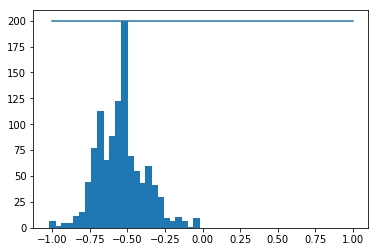

In [8]:
print('total data',len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)  
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
print('removed',len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('Remaining data', len(data))

hist,_ =np.histogram(data['steering'],(num_bins))

plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))
    

In [9]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)): 
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_path = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_path, steerings


image_paths, steerings =  load_img_steering(datadir +'/IMG',  data)

center      center_2019_04_19_19_12_24_847.jpg
left        left_2019_04_19_19_12_24_847.jpg  
right       right_2019_04_19_19_12_24_847.jpg 
steering   -0.600275                          
throttle    1                                 
reverse     0                                 
speed       2.35009                           
Name: 14, dtype: object


In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training samples: {}\n Valid Samples : {}'.format(len(x_train),len(x_valid)))

Training samples: 876
 Valid Samples : 220


Text(0.5, 1.0, 'Validation  set')

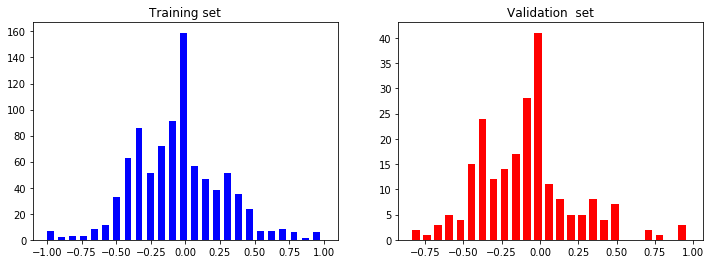

In [11]:
fig , axis = plt.subplots(1,2,figsize=(12,4))
axis[0].hist(y_train, bins=num_bins, width=0.05,color='blue')
axis[0].set_title("Training set")
axis[1].hist(y_valid, bins=num_bins, width=0.05,color='red')
axis[1].set_title("Validation  set")


In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  zoom.augment_image(image)
  return image
  

Text(0.5, 1.0, 'Zoomed image')

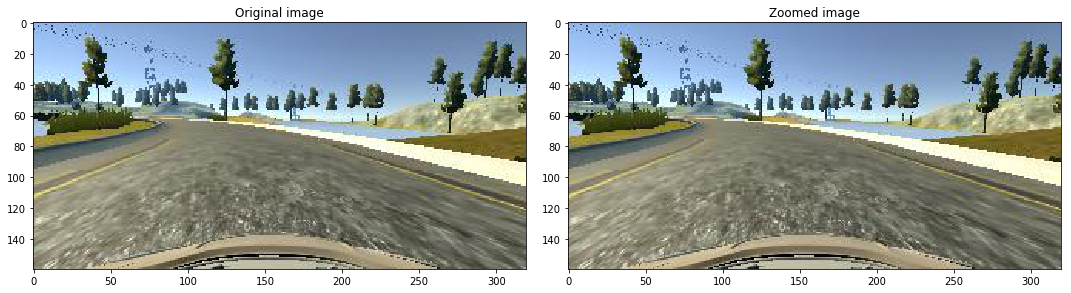

In [13]:
image = image_paths[random.randint(0,800)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
fig, axis = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original image')
axis[1].imshow(zoomed_image)
axis[1].set_title('Zoomed image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1,0.1), "y": (-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'panned image')

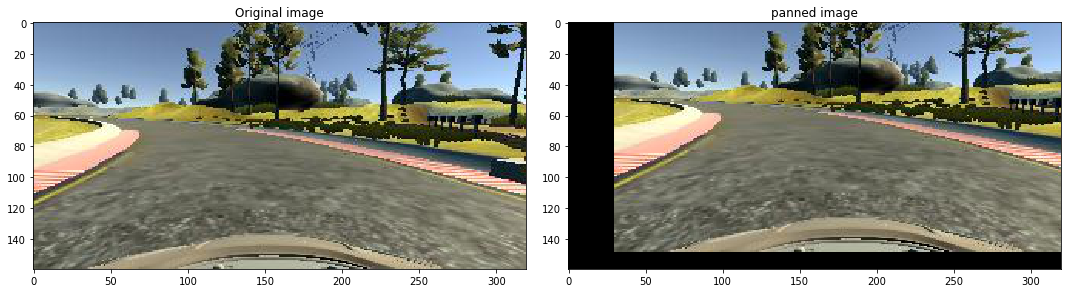

In [34]:
image = image_paths[random.randint(0,800)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
fig, axis = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original image')
axis[1].imshow(panned_image)
axis[1].set_title('panned image')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'brightness altered image')

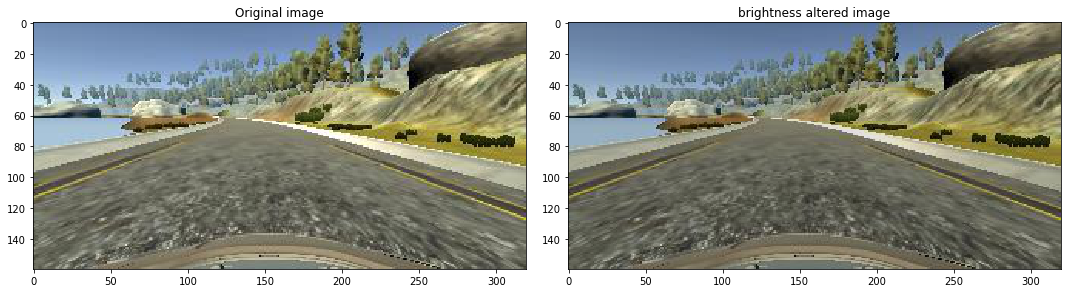

In [49]:
image = image_paths[random.randint(0,800)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axis = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axis[0].imshow(original_image)
axis[0].set_title('Original image')
axis[1].imshow(brightness_altered_image)
axis[1].set_title('brightness altered image')

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image,1) #horizontal flip
  steering_angle = - steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped imageSteering angle-0.46306800000000004')

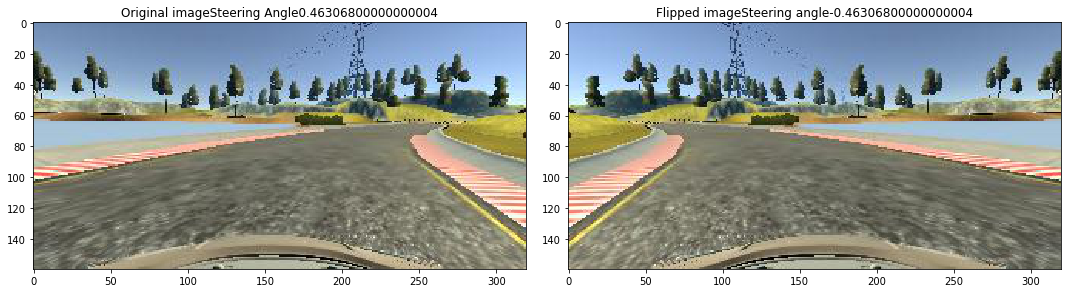

In [53]:
random_index = random.randint(0,800)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axis = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axis[0].imshow(original_image)
axis[0].set_title('Original image' + 'Steering Angle' + str(steering_angle))
axis[1].imshow(flipped_image)
axis[1].set_title('Flipped image'+ 'Steering angle'+ str(flipped_steering_angle))

In [0]:
def random_augment(image,steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5 :
    image = pan(image)
  if np.random.rand() < 0.5 :
    image = zoom(image)
  if np.random.rand() < 0.5 :
    image = img_random_brightness(image)
  if np.random.rand() < 0.5 :
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle  
      

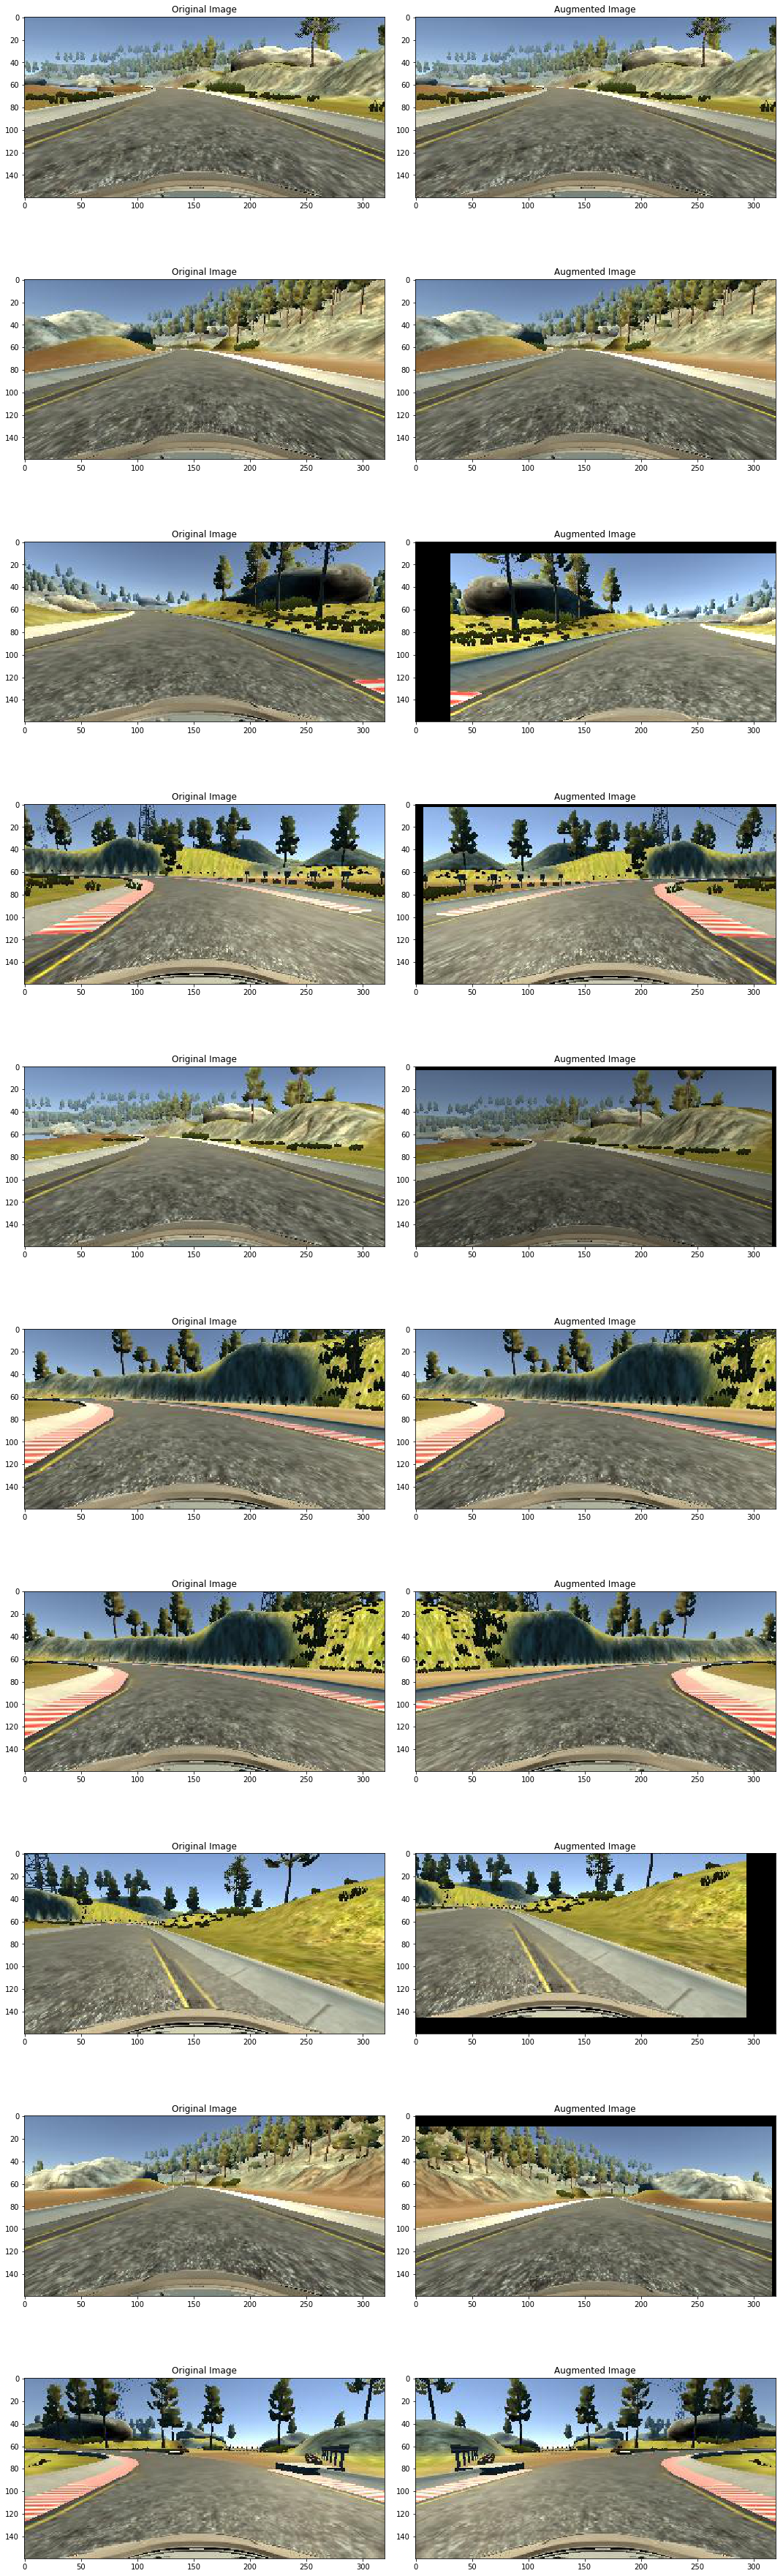

In [65]:
ncol = 2
nrow = 10
fig, axis = plt.subplots(nrow, ncol, figsize=(15,50),)
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  axis[i][0].imshow(original_image)
  axis[i][0].set_title("Original Image")
  
  axis[i][1].imshow(augmented_image)
  axis[i][1].set_title("Augmented Image")

In [0]:
 def img_preprocess(img):
  img = img[60:135,: ,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

In [67]:
image = image_paths[150]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig , axis = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title("Original image")
axis[1].imshow(preprocessed_image)
axis[1].set_title("Processed image")

TypeError: ignored

In [0]:
def batch_generator(image_paths,steering_ang,batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      randon_index = random.randint(0, len(image_paths)-1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
        
      else:
        im = mpimg.imread(image-paths[random_index])
        steering = steering_ang[random_index]
        
      im =img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    
    yield(np.asarray(batch_img), no.asarray(batch_steering))
    

In [71]:
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1 ))
x_valid_gen, y_valid_gen = next(batch_generator(x_valid, y_valid, 1, 0 ))


fig , axis = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axis[0].imshow(x_train_gen[0])
axis[0].set_title("Training Image")
axis[1].imshow(x_valid_gen)
axis[1].set_title("Validation image")

TypeError: ignored

In [0]:
x_train = np.array(list(map(img_preprocess, x_train)))
x_valid = np.array(list(map(img_preprocess, x_valid)))



(876, 66, 200, 3)


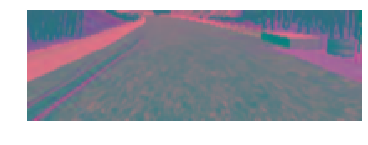

In [19]:
plt.imshow(x_train[random.randint(0,len(x_train)-1)])
plt.axis('off')
print(x_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, 5,5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(48, 5,5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(64, 3,3, activation='elu'))
  model.add(Convolution2D(64, 3,3, activation='elu'))
  model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50,activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10,activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model
  
  

In [21]:
model= nvidia_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [22]:
history = model.fit(x_train, y_train, epochs=30, validation_data = (x_valid,y_valid), batch_size=100, verbose=1,shuffle=1)

Instructions for updating:
Use tf.cast instead.
Train on 876 samples, validate on 220 samples
Epoch 1/30
876/876 [==============================] - 4s 4ms/step - loss: 0.7461 - val_loss: 0.2392
Epoch 2/30
876/876 [==============================] - 0s 511us/step - loss: 0.2549 - val_loss: 0.0915
Epoch 3/30
876/876 [==============================] - 0s 509us/step - loss: 0.1667 - val_loss: 0.0894
Epoch 4/30
876/876 [==============================] - 0s 497us/step - loss: 0.1318 - val_loss: 0.0893
Epoch 5/30
876/876 [==============================] - 0s 510us/step - loss: 0.1124 - val_loss: 0.0854
Epoch 6/30
876/876 [==============================] - 0s 519us/step - loss: 0.1023 - val_loss: 0.0831
Epoch 7/30
876/876 [==============================] - 0s 525us/step - loss: 0.0944 - val_loss: 0.0830
Epoch 8/30
876/876 [==============================] - 0s 530us/step - loss: 0.1021 - val_loss: 0.0804
Epoch 9/30
876/876 [==============================] - 0s 534us/step - loss: 0.0977 - val_los

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python3.6/dist-packages/matp

Text(0.5, 0, 'Epoch')

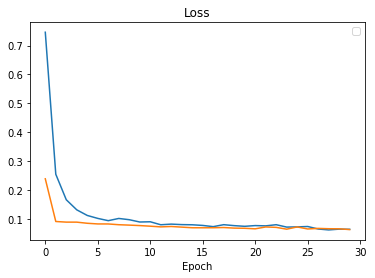

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend('Training', 'Validation')
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')